# U-Net Model Implementation

## Imports

In [ ]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import time

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split

## Configuration Parameters

In [ ]:
# --- File Paths and Names ---
DATA_DIR = '/kaggle/input/aiml-project/train_images_500'
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50'
MODEL_SAVE_DIR = '/kaggle/working/'

# --- Image Parameters ---
IMG_SIZE = 256 
N_IMG_CHANNELS = 3 

# --- Training Parameters ---
VAL_SPLIT_RATIO = 0.15 
BATCH_SIZE = 32 
LEARNING_RATE = 1e-4
EPOCHS = 100        
NOISE_TYPE = 'gauss'
NOISE_LEVEL = 25

BEST_MODEL_NAME = 'n2n_nl'+f'{NOISE_LEVEL}'+'_best.pth' 


# --- Early Stopping & LR Scheduler ---
EARLY_STOPPING_PATIENCE = 10 
LR_SCHEDULER_PATIENCE = 5 
LR_SCHEDULER_FACTOR = 0.2  

# --- U-Net Parameters ---
INIT_FEATURES = 64 
BILINEAR_UPSAMPLE = True 

# --- System Parameters ---
NUM_WORKERS = 0 

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Directory ---
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True)

# --- Reproducibility ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


## Helper Functions (Preprocessing & Noise)

In [ ]:
def preprocess_image(image_path, img_size):
    """Loads, resizes, normalizes, and converts image to PyTorch tensor."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = TF.resize(img, [img_size, img_size], interpolation=TF.InterpolationMode.BILINEAR)
        img_tensor = TF.to_tensor(img)
        if img_tensor.shape[0] != N_IMG_CHANNELS:
             if N_IMG_CHANNELS == 1 and img_tensor.shape[0] == 3: img_tensor = TF.rgb_to_grayscale(img_tensor)
             elif N_IMG_CHANNELS == 3 and img_tensor.shape[0] == 1: img_tensor = TF.grayscale_to_rgb(img_tensor)
             else:
                 print(f"Warning: Channel mismatch for {image_path}. Skipping.")
                 return None
        return img_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}. Skipping.")
        return None

def add_noise(x, noise_type='gauss', noise_level=25):
    """Adds Gaussian or Poisson noise to a clean image tensor."""
    if noise_type == 'gauss':
        std_dev = noise_level / 255.0
        noisy = x + torch.randn_like(x) * std_dev
    elif noise_type == 'poiss':
        noisy = torch.poisson(noise_level * x) / noise_level
    else: # Unknown noise type
        print(f"Warning: Unknown noise type '{noise_type}'. Returning original image.")
        noisy = x
    return torch.clamp(noisy, 0.0, 1.0)

## U-Net Model Definition

In [4]:
class DoubleConv(nn.Module):
    """(Convolution => [BatchNorm] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]; diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__(); self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, init_features=64, bilinear=True):
        super(UNet, self).__init__(); self.n_channels = n_channels; self.n_classes = n_classes; self.bilinear = bilinear
        factor = 2 if bilinear else 1
        self.inc = DoubleConv(n_channels, init_features)
        self.down1 = Down(init_features, init_features * 2); self.down2 = Down(init_features * 2, init_features * 4)
        self.down3 = Down(init_features * 4, init_features * 8); self.down4 = Down(init_features * 8, init_features * 16 // factor)
        self.up1 = Up(init_features * 16, init_features * 8 // factor, bilinear); self.up2 = Up(init_features * 8, init_features * 4 // factor, bilinear)
        self.up3 = Up(init_features * 4, init_features * 2 // factor, bilinear); self.up4 = Up(init_features * 2, init_features, bilinear)
        self.outc = OutConv(init_features, n_classes)
    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1); logits = self.outc(x)
        return logits

## Dataset Definition

In [ ]:
class DenoisingImageDataset(Dataset):
    def __init__(self, image_paths, img_size, noise_type, noise_level, transform=None):
        self.image_paths = image_paths; self.img_size = img_size; self.noise_type = noise_type
        self.noise_level = noise_level; self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            clean_img_tensor = preprocess_image(img_path, self.img_size)
            if clean_img_tensor is None:
                print(f"Warning: Skipping item {idx} due to preprocessing error, trying random next.")
                return self.__getitem__(random.randint(0, len(self) - 1))
            noisy_input = add_noise(clean_img_tensor, self.noise_type, self.noise_level)
            noisy_target = add_noise(clean_img_tensor, self.noise_type, self.noise_level)
            return noisy_input, noisy_target
        except Exception as e:
            print(f"Error in __getitem__ for index {idx}, path {img_path}: {e}")
            return self.__getitem__(random.randint(0, len(self) - 1)) 

## Section 1: Data Loading and Preparation

In [ ]:
print("--- Phase 1: Data Loading and Preparation ---")
all_image_paths = glob.glob(os.path.join(DATA_DIR, '*.[jJ][pP][gG]')) \
                 + glob.glob(os.path.join(DATA_DIR, '*.[pP][nN][gG]')) \
                 + glob.glob(os.path.join(DATA_DIR, '*.[tT][iI][fF][fF]'))

if not all_image_paths:
    print(f"Error: No images found in '{DATA_DIR}'. Please ensure the path is correct and contains images.")
else:
    print(f"Found {len(all_image_paths)} total images in '{DATA_DIR}'.")

    train_paths, val_paths = train_test_split(all_image_paths, test_size=VAL_SPLIT_RATIO, random_state=42)
    print(f"Using {len(train_paths)} images for training, {len(val_paths)} for validation.")

    train_dataset = DenoisingImageDataset(train_paths, IMG_SIZE, NOISE_TYPE, NOISE_LEVEL)
    val_dataset = DenoisingImageDataset(val_paths, IMG_SIZE, NOISE_TYPE, NOISE_LEVEL)

    pin_mem = True if device == torch.device("cuda") else False
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=pin_mem, persistent_workers=(NUM_WORKERS > 0))
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=NUM_WORKERS, pin_memory=pin_mem, persistent_workers=(NUM_WORKERS > 0))

    print("DataLoaders created.")


--- Phase 1: Data Loading and Preparation ---
Found 500 total images in '/kaggle/input/aiml-project/train_images_500'.
Using 425 images for training, 75 for validation.
DataLoaders created.


## Section 2: Model Training

In [ ]:
# --- Initialize Model, Loss, Optimizer, Scheduler ---
print("\n--- Phase 2: Model Training ---")
if 'train_dataloader' not in locals() or 'val_dataloader' not in locals():
     print("DataLoaders not available. Please ensure Section 1 ran successfully and found images.")
else:
    model = UNet(n_channels=N_IMG_CHANNELS, n_classes=N_IMG_CHANNELS, init_features=INIT_FEATURES, bilinear=BILINEAR_UPSAMPLE).to(device)
    print(f"U-Net Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
    train_losses, val_losses = [], []


--- Phase 2: Model Training ---
U-Net Model Parameters: 17,263,107


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training loop...


Epoch 1/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.171576, Val Loss: 0.134264
Val loss improved (inf --> 0.134264). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 2/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 0.033467, Val Loss: 0.024597
Val loss improved (0.134264 --> 0.024597). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 3/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 0.017896, Val Loss: 0.015931
Val loss improved (0.024597 --> 0.015931). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 4/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 0.015507, Val Loss: 0.013664
Val loss improved (0.015931 --> 0.013664). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 5/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 0.014383, Val Loss: 0.012997
Val loss improved (0.013664 --> 0.012997). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 6/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 0.014013, Val Loss: 0.012744
Val loss improved (0.012997 --> 0.012744). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 7/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 0.013282, Val Loss: 0.012551
Val loss improved (0.012744 --> 0.012551). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 8/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 0.013609, Val Loss: 0.012039
Val loss improved (0.012551 --> 0.012039). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 9/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 0.012997, Val Loss: 0.012632
Val loss did not improve for 1 epoch(s).


Epoch 10/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.012906, Val Loss: 0.012511
Val loss did not improve for 2 epoch(s).


Epoch 11/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 0.012576, Val Loss: 0.012648
Val loss did not improve for 3 epoch(s).


Epoch 12/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 0.012901, Val Loss: 0.011445
Val loss improved (0.012039 --> 0.011445). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 13/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 0.013143, Val Loss: 0.013035
Val loss did not improve for 1 epoch(s).


Epoch 14/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 0.012231, Val Loss: 0.012120
Val loss did not improve for 2 epoch(s).


Epoch 15/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 0.013122, Val Loss: 0.012495
Val loss did not improve for 3 epoch(s).


Epoch 16/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 0.012800, Val Loss: 0.011179
Val loss improved (0.011445 --> 0.011179). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 17/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 0.012353, Val Loss: 0.011045
Val loss improved (0.011179 --> 0.011045). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 18/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 0.012600, Val Loss: 0.011625
Val loss did not improve for 1 epoch(s).


Epoch 19/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 0.011923, Val Loss: 0.011234
Val loss did not improve for 2 epoch(s).


Epoch 20/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.012442, Val Loss: 0.011821
Val loss did not improve for 3 epoch(s).


Epoch 21/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 0.012243, Val Loss: 0.010946
Val loss improved (0.011045 --> 0.010946). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 22/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 0.011897, Val Loss: 0.011426
Val loss did not improve for 1 epoch(s).


Epoch 23/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 0.011787, Val Loss: 0.011097
Val loss did not improve for 2 epoch(s).


Epoch 24/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 0.012127, Val Loss: 0.011019
Val loss did not improve for 3 epoch(s).


Epoch 25/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 0.011779, Val Loss: 0.011405
Val loss did not improve for 4 epoch(s).


Epoch 26/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 0.012017, Val Loss: 0.010842
Val loss improved (0.010946 --> 0.010842). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 27/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 0.011746, Val Loss: 0.010831
Val loss improved (0.010842 --> 0.010831). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 28/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 0.011636, Val Loss: 0.011669
Val loss did not improve for 1 epoch(s).


Epoch 29/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 0.011616, Val Loss: 0.011532
Val loss did not improve for 2 epoch(s).


Epoch 30/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.011940, Val Loss: 0.010940
Val loss did not improve for 3 epoch(s).


Epoch 31/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 0.011174, Val Loss: 0.010633
Val loss improved (0.010831 --> 0.010633). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 32/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 0.012052, Val Loss: 0.010728
Val loss did not improve for 1 epoch(s).


Epoch 33/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 0.011604, Val Loss: 0.012201
Val loss did not improve for 2 epoch(s).


Epoch 34/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 0.011720, Val Loss: 0.012277
Val loss did not improve for 3 epoch(s).


Epoch 35/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 0.012407, Val Loss: 0.011070
Val loss did not improve for 4 epoch(s).


Epoch 36/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 0.011898, Val Loss: 0.010623
Val loss improved (0.010633 --> 0.010623). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 37/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 0.012133, Val Loss: 0.010718
Val loss did not improve for 1 epoch(s).


Epoch 38/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 0.011866, Val Loss: 0.010728
Val loss did not improve for 2 epoch(s).


Epoch 39/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 0.011589, Val Loss: 0.010670
Val loss did not improve for 3 epoch(s).


Epoch 40/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.011540, Val Loss: 0.010676
Val loss did not improve for 4 epoch(s).


Epoch 41/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 0.011290, Val Loss: 0.010738
Val loss did not improve for 5 epoch(s).


Epoch 42/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 0.011248, Val Loss: 0.011067
Val loss did not improve for 6 epoch(s).


Epoch 43/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 0.011411, Val Loss: 0.010597
Val loss improved (0.010623 --> 0.010597). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 44/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 0.010978, Val Loss: 0.010410
Val loss improved (0.010597 --> 0.010410). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 45/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 0.011371, Val Loss: 0.010421
Val loss did not improve for 1 epoch(s).


Epoch 46/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 0.010981, Val Loss: 0.010367
Val loss improved (0.010410 --> 0.010367). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 47/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 0.011179, Val Loss: 0.010458
Val loss did not improve for 1 epoch(s).


Epoch 48/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 0.011116, Val Loss: 0.010446
Val loss did not improve for 2 epoch(s).


Epoch 49/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 0.010910, Val Loss: 0.010399
Val loss did not improve for 3 epoch(s).


Epoch 50/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.011031, Val Loss: 0.010425
Val loss did not improve for 4 epoch(s).


Epoch 51/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 0.010837, Val Loss: 0.010348
Val loss improved (0.010367 --> 0.010348). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 52/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 0.010736, Val Loss: 0.010417
Val loss did not improve for 1 epoch(s).


Epoch 53/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 0.011038, Val Loss: 0.010370
Val loss did not improve for 2 epoch(s).


Epoch 54/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 0.010876, Val Loss: 0.010415
Val loss did not improve for 3 epoch(s).


Epoch 55/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 0.010893, Val Loss: 0.010384
Val loss did not improve for 4 epoch(s).


Epoch 56/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 0.010733, Val Loss: 0.010362
Val loss did not improve for 5 epoch(s).


Epoch 57/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 0.010632, Val Loss: 0.010353
Val loss did not improve for 6 epoch(s).


Epoch 58/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 0.010791, Val Loss: 0.010326
Val loss improved (0.010348 --> 0.010326). Saving model to /kaggle/working/n2n_nl25_best.pth


Epoch 59/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 0.010712, Val Loss: 0.010362
Val loss did not improve for 1 epoch(s).


Epoch 60/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.010744, Val Loss: 0.010339
Val loss did not improve for 2 epoch(s).


Epoch 61/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 0.010820, Val Loss: 0.010361
Val loss did not improve for 3 epoch(s).


Epoch 62/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 0.010796, Val Loss: 0.010335
Val loss did not improve for 4 epoch(s).


Epoch 63/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 0.010729, Val Loss: 0.010354
Val loss did not improve for 5 epoch(s).


Epoch 64/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 0.010737, Val Loss: 0.010358
Val loss did not improve for 6 epoch(s).


Epoch 65/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 0.010794, Val Loss: 0.010349
Val loss did not improve for 7 epoch(s).


Epoch 66/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 0.010834, Val Loss: 0.010353
Val loss did not improve for 8 epoch(s).


Epoch 67/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 0.010772, Val Loss: 0.010339
Val loss did not improve for 9 epoch(s).


Epoch 68/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 0.010674, Val Loss: 0.010334
Val loss did not improve for 10 epoch(s).
Early stopping triggered after 68 epochs.
Training Finished. Total time: 14.10 minutes
Best Validation Loss achieved: 0.010326


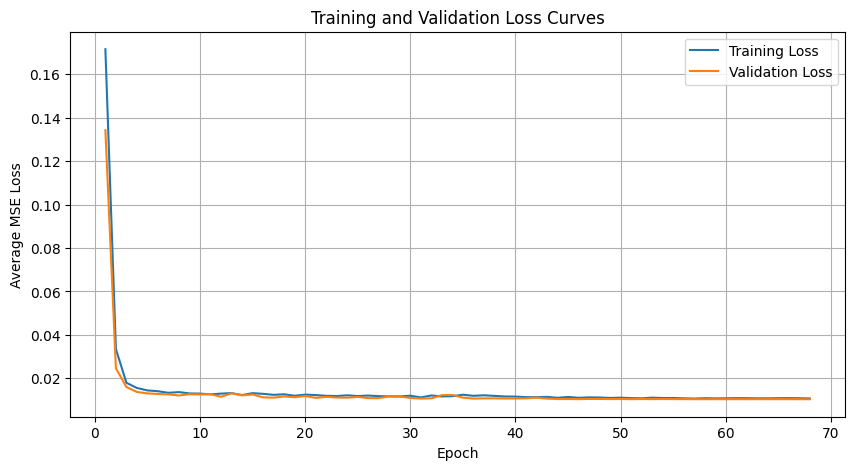

In [ ]:
# --- Training Loop ---
print("Starting training loop...")
start_time = time.time()

for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    running_train_loss = 0.0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for noisy_batch, clean_batch in train_progress_bar:
        noisy_batch = noisy_batch.to(device); clean_batch = clean_batch.to(device)
        optimizer.zero_grad(); predicted_clean_batch = model(noisy_batch)
        loss = criterion(predicted_clean_batch, clean_batch)
        loss.backward(); optimizer.step()
        running_train_loss += loss.item() * noisy_batch.size(0)
        train_progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    avg_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval(); running_val_loss = 0.0
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for noisy_batch, clean_batch in val_progress_bar:
            noisy_batch = noisy_batch.to(device); clean_batch = clean_batch.to(device)
            predicted_clean_batch = model(noisy_batch)
            loss = criterion(predicted_clean_batch, clean_batch)
            running_val_loss += loss.item() * noisy_batch.size(0)
            val_progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    avg_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # --- LR Scheduling, Checkpointing, Early Stopping ---
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        print(f"Val loss improved ({best_val_loss:.6f} --> {avg_val_loss:.6f}). Saving model to {best_model_path}")
        best_val_loss = avg_val_loss
        try: torch.save(model.state_dict(), best_model_path)
        except Exception as e: print(f"Error saving model: {e}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1; print(f"Val loss did not improve for {epochs_no_improve} epoch(s).")
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# --- Training Finished ---
end_time = time.time()
print(f"Training Finished. Total time: {(end_time - start_time)/60:.2f} minutes")
print(f"Best Validation Loss achieved: {best_val_loss:.6f}")

# --- Plot ---
plt.figure(figsize=(10, 5)); plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Average MSE Loss')
plt.title('Training and Validation Loss Curves'); plt.legend(); plt.grid(True); plt.show()

## Section 3: Testing


In [ ]:
# --- Parameters for Testing ---
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
TEST_IMAGE_PATH = '/kaggle/input/aiml-project/491.jpg'
TEST_IMAGE_IS_ALREADY_NOISY = False 
TEST_NOISE_TYPE = 'gauss'
TEST_NOISE_LEVEL = NOISE_LEVEL # same noise as training used 
DENOISE_N_TIMES = 1


In [ ]:
# --- Load Model ---
print("\n--- Phase 3: Testing ---")
print(f"Loading best model from: {SAVED_MODEL_PATH}")
testing_model_loaded = False
try:
    test_model = UNet(n_channels=N_IMG_CHANNELS, n_classes=N_IMG_CHANNELS, init_features=INIT_FEATURES, bilinear=BILINEAR_UPSAMPLE).to(device)
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval()
    print("Best model loaded successfully.")
    testing_model_loaded = True
except FileNotFoundError:
    print(f"Error: Best model file not found at {SAVED_MODEL_PATH}. Cannot perform testing.")
except Exception as e:
    print(f"Error loading model state_dict: {e}. Cannot perform testing.")


--- Phase 3: Testing ---
Loading best model from: /kaggle/working/n2n_nl25_best.pth
Best model loaded successfully.


/tmp/ipykernel_31/655531011.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


Loading test image: /kaggle/input/aiml-project/491.jpg
Adding gauss noise (level 25) to the test image.
Denoising (1 pass(es))...
Denoising complete.
PSNR (Noisy vs Clean): 20.45 dB
PSNR (Final Denoised vs Clean): 25.16 dB


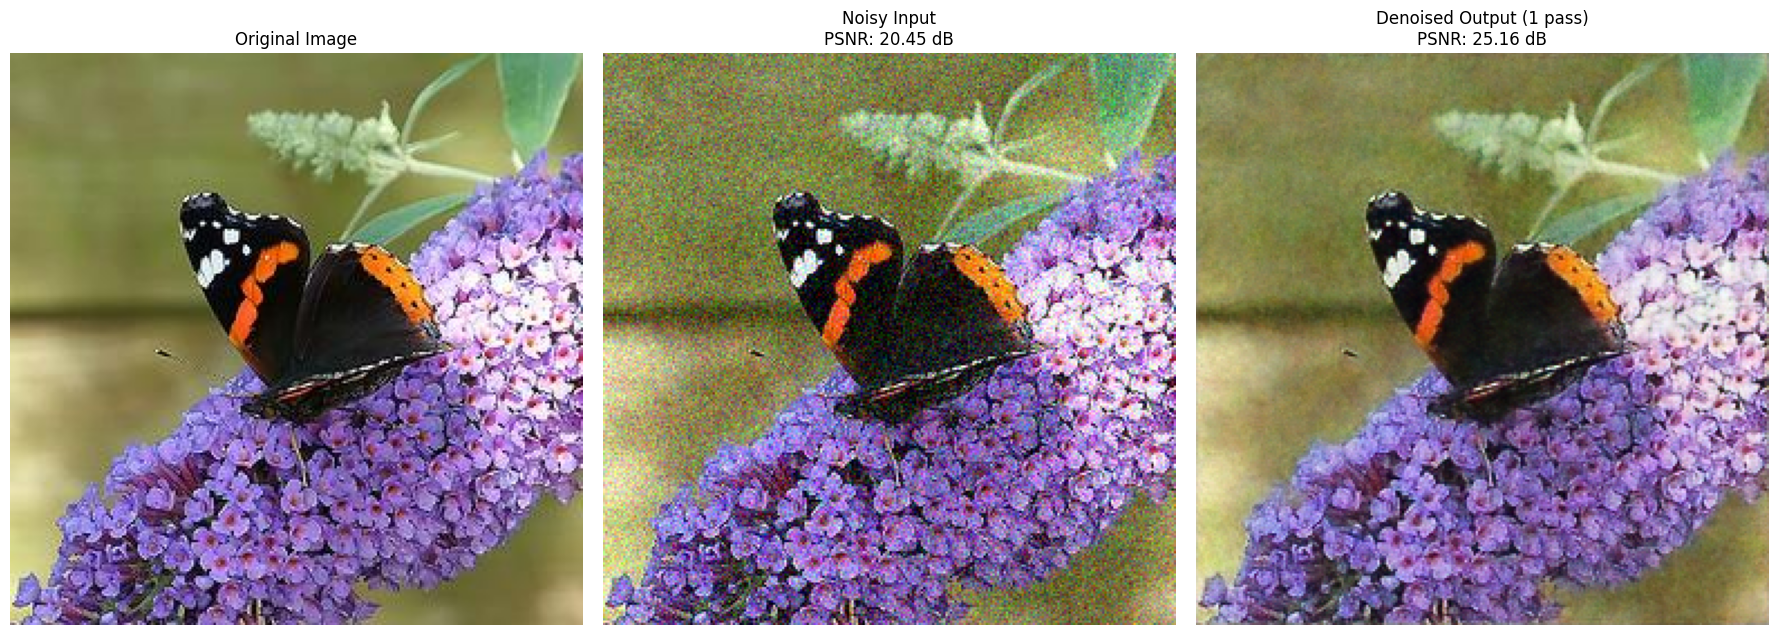

In [ ]:
# --- Load, Prepare, and Denoise Test Image ---
if testing_model_loaded:
    print(f"Loading test image: {TEST_IMAGE_PATH}")
    if not os.path.exists(TEST_IMAGE_PATH):
          print(f"Error: Test image not found at {TEST_IMAGE_PATH}")
          input_tensor = None
    else:
        input_tensor_cpu = preprocess_image(TEST_IMAGE_PATH, IMG_SIZE)
        if input_tensor_cpu is None:
            input_tensor = None
            print("Error: Failed to preprocess test image.")
        else:
            input_tensor = input_tensor_cpu.to(device)

    if input_tensor is not None:
        original_for_display = input_tensor.cpu().clone()

        # --- Noisy Input ---
        if not TEST_IMAGE_IS_ALREADY_NOISY:
            print(f"Adding {TEST_NOISE_TYPE} noise (level {TEST_NOISE_LEVEL}) to the test image.")
            noisy_input_tensor = add_noise(input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)
        else:
            print("Test image is assumed to be already noisy.")
            noisy_input_tensor = input_tensor

        noisy_input_batch = noisy_input_tensor.unsqueeze(0)

        # --- Denoising ---
        print(f"Denoising ({DENOISE_N_TIMES} pass(es))...")
        current_denoised_tensor = noisy_input_tensor
        try:
            with torch.no_grad():
                current_denoised_batch = test_model(current_denoised_tensor.unsqueeze(0))
                current_denoised_tensor = torch.clamp(current_denoised_batch.squeeze(0), 0.0, 1.0)

                for i in range(DENOISE_N_TIMES - 1):
                    current_denoised_batch = test_model(current_denoised_tensor.unsqueeze(0))
                    current_denoised_tensor = torch.clamp(current_denoised_batch.squeeze(0), 0.0, 1.0)

            denoised_output_tensor = current_denoised_tensor
            print("Denoising complete.")

        except Exception as e:
            print(f"An error occurred during denoising: {e}")
            denoised_output_tensor = None

        # --- Calculate PSNR and Display Results ---
        if denoised_output_tensor is not None:
            clean_tensor_device = original_for_display.to(device)

            # PSNR for Noisy vs Clean
            mse_noisy = F.mse_loss(noisy_input_tensor, clean_tensor_device)
            if mse_noisy.item() > 1e-10:
                psnr_noisy = 10 * torch.log10(1.0 / mse_noisy).item()
            else:
                psnr_noisy = float('inf')

            # PSNR for Final Denoised vs Clean
            mse_denoised = F.mse_loss(denoised_output_tensor, clean_tensor_device)
            if mse_denoised.item() > 1e-10:
                psnr_denoised = 10 * torch.log10(1.0 / mse_denoised).item()
            else:
                psnr_denoised = float('inf')

            print(f"PSNR (Noisy vs Clean): {psnr_noisy:.2f} dB")
            print(f"PSNR (Final Denoised vs Clean): {psnr_denoised:.2f} dB")

            noisy_display = noisy_input_tensor.cpu().permute(1, 2, 0).numpy()
            denoised_display = denoised_output_tensor.cpu().permute(1, 2, 0).numpy()
            original_display = original_for_display.permute(1, 2, 0).numpy() # Already on CPU

            # --- Plotting ---
            fig, ax = plt.subplots(1, 3, figsize=(18, 7))

            ax[0].imshow(np.clip(original_display, 0, 1))
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(np.clip(noisy_display, 0, 1))
            ax[1].set_title(f'Noisy Input\nPSNR: {psnr_noisy:.2f} dB')
            ax[1].axis('off')

            ax[2].imshow(np.clip(denoised_display, 0, 1))
            denoised_title = f'Denoised Output ({DENOISE_N_TIMES} pass'
            denoised_title += 'es)' if DENOISE_N_TIMES > 1 else ')'
            denoised_title += f'\nPSNR: {psnr_denoised:.2f} dB'
            ax[2].set_title(denoised_title)
            ax[2].axis('off')

            plt.tight_layout(pad=1.5)
            plt.show()

        else:
            print("Skipping result display as denoising did not complete successfully.")
    else:
        print("Skipping testing phase as test image could not be loaded/processed.")
else:
    print("Skipping testing phase as model could not be loaded.")

In [ ]:
import os
import time
import pandas as pd
import numpy as np 

import torch
import torch.nn as nn 
import torch.nn.functional as F 

TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50' 
CSV_OUTPUT_FILENAME = 'n2n_nl'+f'{NOISE_LEVEL}'+'_psnr.csv'

DENOISE_N_TIMES = 1 
TEST_NOISE_TYPE = 'gauss'
TEST_NOISE_LEVEL = NOISE_LEVEL   

SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)

print("\n--- Preparing for Batch Testing ---")
print(f"Loading best model from: {SAVED_MODEL_PATH}")
testing_model_loaded = False
try:
    test_model = UNet(
        n_channels=N_IMG_CHANNELS,
        n_classes=N_IMG_CHANNELS,
        init_features=INIT_FEATURES,
        bilinear=BILINEAR_UPSAMPLE
    ).to(device)
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval()
    print("Best model loaded successfully.")
    testing_model_loaded = True
except FileNotFoundError:
    print(f"Error: Best model file not found at {SAVED_MODEL_PATH}. Cannot perform testing.")
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
    print(f"Error loading model state_dict: {e}. Cannot perform testing.")
    raise e

if not testing_model_loaded:
    print("Exiting script as model could not be loaded.")
    exit()

if not os.path.isdir(TEST_IMG_DIR):
    print(f"Error: Test image directory not found: {TEST_IMG_DIR}")
    raise FileNotFoundError(f"Test image directory not found: {TEST_IMG_DIR}")

image_extensions = ('.jpg', '.jpeg', '.png')
try:
    all_files = os.listdir(TEST_IMG_DIR)
    image_files = sorted([f for f in all_files if f.lower().endswith(image_extensions)])
except Exception as e:
    print(f"Error listing files in {TEST_IMG_DIR}: {e}")
    raise

if not image_files:
    print(f"No image files with extensions {image_extensions} found in {TEST_IMG_DIR}")
    exit()

print(f"Found {len(image_files)} images to process in {TEST_IMG_DIR}.")

results_data = [] 

print(f"\nStarting batch denoising ({DENOISE_N_TIMES} passes per image) and PSNR calculation...")
start_time = time.time()

for filename in image_files:
    current_image_path = os.path.join(TEST_IMG_DIR, filename)
    print(f"Processing: {filename}...")

    try:
        clean_input_tensor_cpu = preprocess_image(current_image_path, IMG_SIZE)
        if clean_input_tensor_cpu is None:
            print(f"  Skipping {filename} due to preprocessing error.")
            results_data.append({'filename': filename, 'psnr_db': np.nan}) 
            continue

        clean_input_tensor = clean_input_tensor_cpu.to(device)

        noisy_input_tensor = add_noise(clean_input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)

        current_tensor = noisy_input_tensor
        with torch.no_grad():
            for pass_num in range(DENOISE_N_TIMES):
                input_batch = current_tensor.unsqueeze(0)
                output_batch = test_model(input_batch)
                current_tensor = torch.clamp(output_batch.squeeze(0), 0.0, 1.0)

        denoised_output_tensor = current_tensor
        mse_loss = F.mse_loss(denoised_output_tensor, clean_input_tensor)

        if mse_loss.item() > 1e-10:
            psnr = 10 * torch.log10(1.0 / mse_loss)
            current_psnr = psnr.item()
        else:
            current_psnr = float('inf')

        print(f"  Final PSNR after {DENOISE_N_TIMES} passes: {current_psnr:.2f} dB")

        results_data.append({'filename': filename, 'psnr_db': current_psnr})

    except Exception as e:
        print(f"  Error processing {filename}: {e}")
        results_data.append({'filename': filename, 'psnr_db': np.nan})

end_time = time.time()
print(f"\nBatch processing completed in {end_time - start_time:.2f} seconds.")

# --- Calculate Average PSNR and Save Results ---
if results_data:
    results_df = pd.DataFrame(results_data)
    valid_psnr_values = results_df['psnr_db'].replace([np.inf, -np.inf], np.nan).dropna()
    if not valid_psnr_values.empty:
        average_psnr = valid_psnr_values.mean()
        print(f"\nAverage PSNR over {len(valid_psnr_values)} successfully processed images: {average_psnr:.2f} dB")
    else:
        average_psnr = np.nan 
        print("\nCould not calculate average PSNR (no valid results).")

    try:
        results_df.to_csv(CSV_OUTPUT_FILENAME, index=False)
        print(f"Results saved to {CSV_OUTPUT_FILENAME}")
    except Exception as e:
        print(f"Error saving results to CSV ({CSV_OUTPUT_FILENAME}): {e}")
else:
    print("No images were processed.")

print("\nScript finished.")


--- Preparing for Batch Testing ---
Loading best model from: /kaggle/working/n2n_nl25_best.pth


/tmp/ipykernel_31/3111512129.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


Best model loaded successfully.
Found 50 images to process in /kaggle/input/aiml-project/test_images_50.

Starting batch denoising (1 passes per image) and PSNR calculation...
Processing: 01.png...
  Final PSNR after 1 passes: 28.30 dB
Processing: 02.png...
  Final PSNR after 1 passes: 26.86 dB
Processing: 03.png...
  Final PSNR after 1 passes: 25.48 dB
Processing: 04.png...
  Final PSNR after 1 passes: 25.17 dB
Processing: 05.png...
  Final PSNR after 1 passes: 28.67 dB
Processing: 06.png...
  Final PSNR after 1 passes: 29.07 dB
Processing: 07.png...
  Final PSNR after 1 passes: 26.66 dB
Processing: 08.png...
  Final PSNR after 1 passes: 28.48 dB
Processing: 09.png...
  Final PSNR after 1 passes: 25.24 dB
Processing: 10.png...
  Final PSNR after 1 passes: 27.03 dB
Processing: 11.png...
  Final PSNR after 1 passes: 28.68 dB
Processing: 12.png...
  Final PSNR after 1 passes: 27.31 dB
Processing: 13.png...
  Final PSNR after 1 passes: 26.23 dB
Processing: 14.png...
  Final PSNR after 1 p